<a href="https://colab.research.google.com/github/umbertogagl97/Tesi/blob/main/Impronte/AttaccoScanner/Attacco_FGM_confidence_iter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Init**

##Import ART

In [1]:
#importa ART
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 1.1 MB 5.1 MB/s 
     |████████████████████████████████| 3.3 MB 38.4 MB/s 
     |████████████████████████████████| 26.3 MB 65.5 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


## Import librerie

In [2]:
#Librerie

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
#import time
#import os
#import shutil
#import copy

import pandas as pd
import matplotlib.pyplot as plt
import sys


##Check device


In [3]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

1.9.0+cu111
True
Tesla P100-PCIE-16GB
cuda:0


##Transforms

In [14]:
from torchvision.transforms.functional import InterpolationMode
transf_init=transforms.Resize(size=(1000,1000),interpolation=InterpolationMode.NEAREST)

##Def path

In [4]:
#scanner
scanner_name = 'HiScan'

#salvataggio modello
model_name = 'VGG19_10epoc_lr5_bs200_adam'
path_model = F"/content/gdrive/My Drive/ModelliCNN/Scanner/{scanner_name}/{model_name}" 

#dataset
pathTestset=F'/content/gdrive/MyDrive/Dataset_impronte/test/{scanner_name}'

pd_preds_value=F'/content/gdrive/MyDrive/Dataset_impronte/test/Preds_value/{scanner_name}.xlsx'

data_transform_test= transforms.Compose([transforms.Resize([224,224]),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])

##Collegamento google drive

In [5]:
#collegamento google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#**Dataset**

##Caricamento dataset

In [6]:
test_dataset = datasets.ImageFolder(pathTestset,transforms.ToTensor())
dim_set=len(test_dataset)
print(dim_set)

2500


##Dataloader

In [7]:
testgen=torch.utils.data.DataLoader(test_dataset, pin_memory=True, batch_size=1,num_workers=2)
print(len(testgen))

2500


##Nomi classi

In [8]:
classes_name=test_dataset.classes
class_number=len(classes_name)
print(classes_name)
print(class_number)
#del test_dataset

['Live', 'Spoof']
2


#**Riduzione dataset**

In [ ]:
test_dataset.samples=test_dataset.samples[1000:1050]
test_dataset.targets=test_dataset.targets[1000:1050]

dim_set=len(test_dataset)
print(dim_set)

50


# **Creazione modello**

> non ho bloccato i parametri inferiori e sbloccato quelli del classificatore, vedi se funziona



##Load model pre-trained

In [9]:
model = models.vgg19(pretrained=True,progress=True)
#model = models.densenet201(pretrained=True,progress=True)
#print(model)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

##Aggiunta classificatore

In [10]:
model.classifier[6]=nn.Linear(4096,2) #per vgg19
#model.classifier=nn.Linear(1920,2) #per densenet201

#print(model) 

##Load pesi

In [11]:
model.load_state_dict(torch.load(path_model))#,map_location=torch.device('cpu')))


<All keys matched successfully>

# **Def funzioni**

##calc size

In [15]:
def calc_size(n):
  '''
  n: int 
  return: 80% of n
  '''
  return tuple(int(np.ceil(i * (80/100))) for i in n)

##Testing

con media senza datframe

In [16]:
def test_average_preds(classifier,test_loader,):
  '''
  model: model trained
  test_loader: dataloader 
  return: dataframe{n_img,class_predicted,class_real}
  '''
  preds=[]
  #value=[]
  prob=nn.Softmax()
  data_transform_test= transforms.Compose([transforms.Resize([224,224]),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
  i=0
  for input,label in test_loader:
    i+=1
    input=transf_init(input) #resize 1000
    n=input.shape
    n_mod=calc_size(n[2:4])
    crop_transform=transforms.TenCrop((n_mod[0],n_mod[1]))
    crops=crop_transform(input)
    live=0
    spoof=0
    for crop in crops:
      crop=data_transform_test(crop) #resize 224
      outputs = classifier.predict(crop)
      live+=outputs[0][0]
      spoof+=outputs[0][1]
    live=live/10
    spoof=spoof/10
    predicted=np.argmax([live,spoof])
    preds.append(predicted)
    #value.append(np.max(prob(torch.Tensor([live,spoof])).numpy()))
    value=np.max(prob(torch.Tensor([live,spoof])).numpy())

  return np.array(preds),value

##Array to dataloader

In [17]:
from torch.utils.data import TensorDataset, DataLoader

def array2dataloader(x,y):
  '''
  :param x: ndarray x_test;
  :param y: labels
  '''
  tensor_x = torch.Tensor(x) # transform to torch tensor
  tensor_y = torch.Tensor(np.argmax(y,axis=1))

  my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
  return DataLoader(my_dataset) 

##FGM mod

In [18]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
from typing import Optional, Union, TYPE_CHECKING

import numpy as np

from art.config import ART_NUMPY_DTYPE
from art.attacks.attack import EvasionAttack
from art.estimators.estimator import BaseEstimator, LossGradientsMixin
from art.estimators.classification.classifier import ClassifierMixin
from art.utils import (
    compute_success,
    get_labels_np_array,
    random_sphere,
    projection,
    check_and_transform_label_format,
)

if TYPE_CHECKING:
    from art.utils import CLASSIFIER_LOSS_GRADIENTS_TYPE

logger = logging.getLogger(__name__)


class FastGradientMethod_mod(EvasionAttack):
    """
    This attack was originally implemented by Goodfellow et al. (2015) with the infinity norm (and is known as the "Fast
    Gradient Sign Method"). This implementation extends the attack to other norms, and is therefore called the Fast
    Gradient Method.
    | Paper link: https://arxiv.org/abs/1412.6572
    """

    attack_params = EvasionAttack.attack_params + [
        "norm",
        "eps",
        "eps_step",
        "targeted",
        "num_random_init",
        "batch_size",
        "minimal",
        "tensor_board",
    ]
    _estimator_requirements = (BaseEstimator, LossGradientsMixin)

    def __init__(
        self,
        estimator: "CLASSIFIER_LOSS_GRADIENTS_TYPE",
        norm: Union[int, float, str] = np.inf,
        eps: Union[int, float, np.ndarray] = 0.3,
        eps_step: Union[int, float, np.ndarray] = 0.1,
        targeted: bool = False,
        num_random_init: int = 0,
        batch_size: int = 32,
        minimal: bool = False,
        tensor_board: Union[str, bool] = False,
    ) -> None:
        """
        Create a :class:`.FastGradientMethod` instance.
        :param estimator: A trained classifier.
        :param norm: The norm of the adversarial perturbation. Possible values: "inf", np.inf, 1 or 2.
        :param eps: Attack step size (input variation).
        :param eps_step: Step size of input variation for minimal perturbation computation.
        :param targeted: Indicates whether the attack is targeted (True) or untargeted (False)
        :param num_random_init: Number of random initialisations within the epsilon ball. For random_init=0 starting at
            the original input.
        :param batch_size: Size of the batch on which adversarial samples are generated.
        :param minimal: Indicates if computing the minimal perturbation (True). If True, also define `eps_step` for
                        the step size and eps for the maximum perturbation.
        :param tensor_board: Activate summary writer for TensorBoard: Default is `False` and deactivated summary writer.
                             If `True` save runs/CURRENT_DATETIME_HOSTNAME in current directory. Provide `path` in type
                             `str` to save in path/CURRENT_DATETIME_HOSTNAME.
                             Use hierarchical folder structure to compare between runs easily. e.g. pass in ‘runs/exp1’,
                             ‘runs/exp2’, etc. for each new experiment to compare across them.
        """
        super().__init__(estimator=estimator, tensor_board=tensor_board)
        self.norm = norm
        self.eps = eps
        self.eps_step = eps_step
        self._targeted = targeted
        self.num_random_init = num_random_init
        self.batch_size = batch_size
        self.minimal = minimal
        self._project = True
        FastGradientMethod_mod._check_params(self)

        self._batch_id = 0
        self._i_max_iter = 0

    def _check_compatibility_input_and_eps(self, x: np.ndarray):
        """
        Check the compatibility of the input with `eps` and `eps_step` which are of the same shape.
        :param x: An array with the original inputs.
        """
        if isinstance(self.eps, np.ndarray):
            # Ensure the eps array is broadcastable
            if self.eps.ndim > x.ndim:
                raise ValueError("The `eps` shape must be broadcastable to input shape.")

    def _minimal_perturbation(self, x: np.ndarray, y: np.ndarray, target, class_target, max_iter, confidence, mask: np.ndarray) -> np.ndarray:
        """
        Iteratively compute the minimal perturbation necessary to make the class prediction change. Stop when the
        first adversarial example was found.
        :param x: An array with the original inputs.
        :param y: Target values (class labels) one-hot-encoded of shape (nb_samples, nb_classes).
        :param target: targeted attack (mirato a far predire una specifica classe)
        :param class_target: class da predire se target=True (nel nostro caso vogliamo far predire sempre live)
        :return: An array holding the adversarial examples.
        """
        adv_x = x.copy()
        
        n_batch=int(np.ceil(adv_x.shape[0] / float(self.batch_size)))
        # Compute perturbation with implicit batching
        for batch_id in range(n_batch):
            batch_index_1, batch_index_2 = (
                batch_id * self.batch_size,
                (batch_id + 1) * self.batch_size,
            )
            batch = adv_x[batch_index_1:batch_index_2]
            batch_labels = y[batch_index_1:batch_index_2]

            #sys.stdout.write("\rBatch {0}/{1}".format(batch_id,n_batch))
            #sys.stdout.flush()

            mask_batch = mask
            if mask is not None:
                # Here we need to make a distinction: if the masks are different for each input, we need to index
                # those for the current batch. Otherwise (i.e. mask is meant to be broadcasted), keep it as it is.
                if len(mask.shape) == len(x.shape):
                    mask_batch = mask[batch_index_1:batch_index_2]

            # Get perturbation
            perturbation = self._compute_perturbation(batch, batch_labels, mask_batch)

            if target:
              #print("mod")
              #print("class_target "+str(class_target))
              
              preds,value=test_average_preds(self.estimator,array2dataloader(batch,batch_labels))
              if ((preds==np.argmax(batch_labels, axis=1)) and (preds!= class_target)):
                #print("preds=label e preds=spoof")
                active_indices=True
              elif ((preds!=np.argmax(batch_labels, axis=1)) and (preds== class_target) and (value<confidence)): 
                #print("preds=label, preds=live e confidence<0.6")
                active_indices=True
              else:  active_indices=False
              #active_indices=np.where(((preds==np.argmax(batch_labels, axis=1)) and (preds!= class_target)) or ((preds!=np.argmax(batch_labels, axis=1)) and (preds== class_target) and (value>confidence)))[0]
              
              #print("labels "+str(np.argmax(batch_labels, axis=1)))
              #print("preds: "+str(preds))
              #print("active: "+str(active_indices))
            else:
              # Get current predictions
              np.where(np.argmax(batch_labels, axis=1) == preds )[0]
            
            if isinstance(self.eps, np.ndarray) and isinstance(self.eps_step, np.ndarray):
                if len(self.eps.shape) == len(x.shape) and self.eps.shape[0] == x.shape[0]:
                    current_eps = self.eps_step[batch_index_1:batch_index_2]
                    partial_stop_condition = (current_eps <= self.eps[batch_index_1:batch_index_2]).all()

                else:
                    current_eps = self.eps_step
                    partial_stop_condition = (current_eps <= self.eps).all()

            else:
                current_eps = self.eps_step
                partial_stop_condition = current_eps <= self.eps
            iter=0
            while active_indices==True and partial_stop_condition and iter<max_iter:
                iter+=1
                #print("iter: "+str(iter))
                # Adversarial crafting
                current_x = self._apply_perturbation(x[batch_index_1:batch_index_2], perturbation, current_eps)

                # Update
                #batch[active_indices] = current_x[active_indices]
                batch = current_x
                preds,value=test_average_preds(self.estimator,array2dataloader(batch,batch_labels))
                #print(preds,value)
                #print(batch_labels)
                # If targeted active check to see whether we have hit the target, otherwise head to anything but
                if self.targeted:
                    active_indices = np.where(np.argmax(batch_labels, axis=1) != np.argmax(preds, axis=1))[0]
                else:
                    if target:
                      if ((preds==np.argmax(batch_labels, axis=1)) and (preds!= class_target)):
                        #print("preds=label e preds=spoof")
                        active_indices=True
                      elif ((preds!=np.argmax(batch_labels, axis=1)) and (preds== class_target) and (value<confidence)): 
                        #print("preds=label, preds=live e confidence<0.6")
                        active_indices=True
                      else:  active_indices=False
                    else:
                      active_indices = np.where(np.argmax(batch_labels, axis=1) == preds )[0]
                    #print("preds: "+str(preds))
                    #print("active_ind: "+str(active_indices))

                # Update current eps and check the stop condition
                if isinstance(self.eps, np.ndarray) and isinstance(self.eps_step, np.ndarray):
                    if len(self.eps.shape) == len(x.shape) and self.eps.shape[0] == x.shape[0]:
                        current_eps = current_eps + self.eps_step[batch_index_1:batch_index_2]
                        partial_stop_condition = (current_eps <= self.eps[batch_index_1:batch_index_2]).all()

                    else:
                        current_eps = current_eps + self.eps_step
                        partial_stop_condition = (current_eps <= self.eps).all()

                else:
                    current_eps = current_eps + self.eps_step
                    partial_stop_condition = current_eps <= self.eps

            adv_x[batch_index_1:batch_index_2] = batch

        return adv_x

    def generate(self, x: np.ndarray, y: Optional[np.ndarray] = None, target=False, class_target=None, max_iter=10, confidence=0.6, **kwargs) -> np.ndarray:
        """Generate adversarial samples and return them in an array.
        :param x: An array with the original inputs.
        :param y: Target values (class labels) one-hot-encoded of shape (nb_samples, nb_classes) or indices of shape
                  (nb_samples,). Only provide this parameter if you'd like to use true labels when crafting adversarial
                  samples. Otherwise, model predictions are used as labels to avoid the "label leaking" effect
                  (explained in this paper: https://arxiv.org/abs/1611.01236). Default is `None`.
        :param target: indica se l'attacco è mirato a far predire una determinata classe.
        :param class_target: se target=True specifica quale classe far predire.
        :param max_iter: numero massimo di iterazioni da effettuare su ogni singolo batch nel caso minimal.
        :param confidence: indica la probabilità minima con la quale il classificatore deve predire una classe affinché l'attacco si arresti.          
        :param mask: An array with a mask broadcastable to input `x` defining where to apply adversarial perturbations.
                     Shape needs to be broadcastable to the shape of x and can also be of the same shape as `x`. Any
                     features for which the mask is zero will not be adversarially perturbed.
        :type mask: `np.ndarray`
        :return: An array holding the adversarial examples.
        """
        mask = self._get_mask(x, **kwargs)

        # Ensure eps is broadcastable
        self._check_compatibility_input_and_eps(x=x)

        if isinstance(self.estimator, ClassifierMixin):
            y = check_and_transform_label_format(y, self.estimator.nb_classes)

            if y is None:
                # Throw error if attack is targeted, but no targets are provided
                if self.targeted:
                    raise ValueError("Target labels `y` need to be provided for a targeted attack.")

                # Use model predictions as correct outputs
                logger.info("Using model predictions as correct labels for FGM.")
                y = get_labels_np_array(self.estimator.predict(x, batch_size=self.batch_size))  # type: ignore

            if self.estimator.nb_classes > 2:
                y = y / np.sum(y, axis=1, keepdims=True)

            # Return adversarial examples computed with minimal perturbation if option is active
            rate_best: Optional[float]
            if self.minimal:
                logger.info("Performing minimal perturbation FGM.")
                adv_x_best = self._minimal_perturbation(x, y, target, class_target, max_iter, confidence, mask)
                rate_best = 100 * compute_success(
                    self.estimator,  # type: ignore
                    x,
                    y,
                    adv_x_best,
                    self.targeted,
                    batch_size=self.batch_size,  # type: ignore
                )
            else:
                adv_x_best = None
                rate_best = None

                for _ in range(max(1, self.num_random_init)):
                    adv_x = self._compute(
                        x,
                        x,
                        y,
                        mask,
                        self.eps,
                        self.eps,
                        self._project,
                        self.num_random_init > 0,
                    )

                    if self.num_random_init > 1:
                        rate = 100 * compute_success(
                            self.estimator,  # type: ignore
                            x,
                            y,
                            adv_x,
                            self.targeted,
                            batch_size=self.batch_size,  # type: ignore
                        )
                        if rate_best is None or rate > rate_best or adv_x_best is None:
                            rate_best = rate
                            adv_x_best = adv_x
                    else:
                        adv_x_best = adv_x

            logger.info(
                "Success rate of FGM attack: %.2f%%",
                rate_best
                if rate_best is not None
                else 100
                * compute_success(
                    self.estimator,  # type: ignore
                    x,
                    y,
                    adv_x_best,
                    self.targeted,
                    batch_size=self.batch_size,
                ),
            )

        else:
            if self.minimal:
                raise ValueError("Minimal perturbation is only supported for classification.")

            if y is None:
                # Throw error if attack is targeted, but no targets are provided
                if self.targeted:
                    raise ValueError("Target labels `y` need to be provided for a targeted attack.")

                # Use model predictions as correct outputs
                logger.info("Using model predictions as correct labels for FGM.")
                y = self.estimator.predict(x, batch_size=self.batch_size)

            adv_x_best = self._compute(
                x,
                x,
                y,
                None,
                self.eps,
                self.eps,
                self._project,
                self.num_random_init > 0,
            )

        return adv_x_best

    def _check_params(self) -> None:

        if self.norm not in [1, 2, np.inf, "inf"]:
            raise ValueError('Norm order must be either 1, 2, `np.inf` or "inf".')

        if not (
            isinstance(self.eps, (int, float))
            and isinstance(self.eps_step, (int, float))
            or isinstance(self.eps, np.ndarray)
            and isinstance(self.eps_step, np.ndarray)
        ):
            raise TypeError(
                "The perturbation size `eps` and the perturbation step-size `eps_step` must have the same type of `int`"
                ", `float`, or `np.ndarray`."
            )

        if isinstance(self.eps, (int, float)):
            if self.eps < 0:
                raise ValueError("The perturbation size `eps` has to be nonnegative.")
        else:
            if (self.eps < 0).any():
                raise ValueError("The perturbation size `eps` has to be nonnegative.")

        if isinstance(self.eps_step, (int, float)):
            if self.eps_step <= 0:
                raise ValueError("The perturbation step-size `eps_step` has to be positive.")
        else:
            if (self.eps_step <= 0).any():
                raise ValueError("The perturbation step-size `eps_step` has to be positive.")

        if isinstance(self.eps, np.ndarray) and isinstance(self.eps_step, np.ndarray):
            if self.eps.shape != self.eps_step.shape:
                raise ValueError(
                    "The perturbation size `eps` and the perturbation step-size `eps_step` must have the same shape."
                )

        if not isinstance(self.targeted, bool):
            raise ValueError("The flag `targeted` has to be of type bool.")

        if not isinstance(self.num_random_init, (int, np.int)):
            raise TypeError("The number of random initialisations has to be of type integer")

        if self.num_random_init < 0:
            raise ValueError("The number of random initialisations `random_init` has to be greater than or equal to 0.")

        if self.batch_size <= 0:
            raise ValueError("The batch size `batch_size` has to be positive.")

        if not isinstance(self.minimal, bool):
            raise ValueError("The flag `minimal` has to be of type bool.")

    def _compute_perturbation(
        self, batch: np.ndarray, batch_labels: np.ndarray, mask: Optional[np.ndarray]
    ) -> np.ndarray:
        # Pick a small scalar to avoid division by 0
        tol = 10e-8

        # Get gradient wrt loss; invert it if attack is targeted
        grad = self.estimator.loss_gradient(batch, batch_labels) * (1 - 2 * int(self.targeted))

        # Write summary
        if self.summary_writer is not None:
            self.summary_writer.add_scalar(
                "gradients/norm-L1/batch-{}".format(self._batch_id),
                np.linalg.norm(grad.flatten(), ord=1),
                global_step=self._i_max_iter,
            )
            self.summary_writer.add_scalar(
                "gradients/norm-L2/batch-{}".format(self._batch_id),
                np.linalg.norm(grad.flatten(), ord=2),
                global_step=self._i_max_iter,
            )
            self.summary_writer.add_scalar(
                "gradients/norm-Linf/batch-{}".format(self._batch_id),
                np.linalg.norm(grad.flatten(), ord=np.inf),
                global_step=self._i_max_iter,
            )

            if hasattr(self.estimator, "compute_losses"):
                losses = self.estimator.compute_losses(x=batch, y=batch_labels)

                for key, value in losses.items():
                    self.summary_writer.add_scalar(
                        "loss/{}/batch-{}".format(key, self._batch_id),
                        np.mean(value.detach().cpu().numpy()),
                        global_step=self._i_max_iter,
                    )

        # Check for NaN before normalisation an replace with 0
        if grad.dtype != np.object and np.isnan(grad).any():
            logger.warning("Elements of the loss gradient are NaN and have been replaced with 0.0.")
            grad = np.where(np.isnan(grad), 0.0, grad)
        else:
            for i, _ in enumerate(grad):
                grad_i_array = grad[i].astype(np.float32)
                if np.isnan(grad_i_array).any():
                    grad[i] = np.where(np.isnan(grad_i_array), 0.0, grad_i_array).astype(np.object)

        # Apply mask
        if mask is not None:
            grad = np.where(mask == 0.0, 0.0, grad)

        # Apply norm bound
        def _apply_norm(grad, object_type=False):
            if (grad.dtype != np.object and np.isinf(grad).any()) or np.isnan(grad.astype(np.float32)).any():
                logger.info("The loss gradient array contains at least one positive or negative infinity.")

            if self.norm in [np.inf, "inf"]:
                grad = np.sign(grad)
            elif self.norm == 1:
                if not object_type:
                    ind = tuple(range(1, len(batch.shape)))
                else:
                    ind = None
                grad = grad / (np.sum(np.abs(grad), axis=ind, keepdims=True) + tol)
            elif self.norm == 2:
                if not object_type:
                    ind = tuple(range(1, len(batch.shape)))
                else:
                    ind = None
                grad = grad / (np.sqrt(np.sum(np.square(grad), axis=ind, keepdims=True)) + tol)
            return grad

        if batch.dtype == np.object:
            for i_sample in range(batch.shape[0]):
                grad[i_sample] = _apply_norm(grad[i_sample], object_type=True)
                assert batch[i_sample].shape == grad[i_sample].shape
        else:
            grad = _apply_norm(grad)

        assert batch.shape == grad.shape

        return grad

    def _apply_perturbation(
        self, batch: np.ndarray, perturbation: np.ndarray, eps_step: Union[int, float, np.ndarray]
    ) -> np.ndarray:

        perturbation_step = eps_step * perturbation
        if perturbation_step.dtype != np.object:
            perturbation_step[np.isnan(perturbation_step)] = 0
        else:
            for i, _ in enumerate(perturbation_step):
                perturbation_step_i_array = perturbation_step[i].astype(np.float32)
                if np.isnan(perturbation_step_i_array).any():
                    perturbation_step[i] = np.where(
                        np.isnan(perturbation_step_i_array), 0.0, perturbation_step_i_array
                    ).astype(np.object)

        batch = batch + perturbation_step
        if self.estimator.clip_values is not None:
            clip_min, clip_max = self.estimator.clip_values
            batch = np.clip(batch, clip_min, clip_max)

        return batch

    def _compute(
        self,
        x: np.ndarray,
        x_init: np.ndarray,
        y: np.ndarray,
        mask: Optional[np.ndarray],
        eps: Union[int, float, np.ndarray],
        eps_step: Union[int, float, np.ndarray],
        project: bool,
        random_init: bool,
    ) -> np.ndarray:
        if random_init:
            n = x.shape[0]
            m = np.prod(x.shape[1:]).item()
            random_perturbation = random_sphere(n, m, eps, self.norm).reshape(x.shape).astype(ART_NUMPY_DTYPE)
            if mask is not None:
                random_perturbation = random_perturbation * (mask.astype(ART_NUMPY_DTYPE))
            x_adv = x.astype(ART_NUMPY_DTYPE) + random_perturbation

            if self.estimator.clip_values is not None:
                clip_min, clip_max = self.estimator.clip_values
                x_adv = np.clip(x_adv, clip_min, clip_max)
        else:
            if x.dtype == np.object:
                x_adv = x.copy()
            else:
                x_adv = x.astype(ART_NUMPY_DTYPE)

        # Compute perturbation with implicit batching
        for batch_id in range(int(np.ceil(x.shape[0] / float(self.batch_size)))):
            self._batch_id = batch_id
            batch_index_1, batch_index_2 = batch_id * self.batch_size, (batch_id + 1) * self.batch_size
            batch_index_2 = min(batch_index_2, x.shape[0])
            batch = x_adv[batch_index_1:batch_index_2]
            batch_labels = y[batch_index_1:batch_index_2]

            mask_batch = mask
            if mask is not None:
                # Here we need to make a distinction: if the masks are different for each input, we need to index
                # those for the current batch. Otherwise (i.e. mask is meant to be broadcasted), keep it as it is.
                if len(mask.shape) == len(x.shape):
                    mask_batch = mask[batch_index_1:batch_index_2]

            # Get perturbation
            perturbation = self._compute_perturbation(batch, batch_labels, mask_batch)

            # Compute batch_eps and batch_eps_step
            if isinstance(eps, np.ndarray) and isinstance(eps_step, np.ndarray):
                if len(eps.shape) == len(x.shape) and eps.shape[0] == x.shape[0]:
                    batch_eps = eps[batch_index_1:batch_index_2]
                    batch_eps_step = eps_step[batch_index_1:batch_index_2]

                else:
                    batch_eps = eps
                    batch_eps_step = eps_step

            else:
                batch_eps = eps
                batch_eps_step = eps_step

            # Apply perturbation and clip
            x_adv[batch_index_1:batch_index_2] = self._apply_perturbation(batch, perturbation, batch_eps_step)

            if project:
                if x_adv.dtype == np.object:
                    for i_sample in range(batch_index_1, batch_index_2):
                        if isinstance(batch_eps, np.ndarray) and batch_eps.shape[0] == x_adv.shape[0]:
                            perturbation = projection(
                                x_adv[i_sample] - x_init[i_sample], batch_eps[i_sample], self.norm
                            )

                        else:
                            perturbation = projection(x_adv[i_sample] - x_init[i_sample], batch_eps, self.norm)

                        x_adv[i_sample] = x_init[i_sample] + perturbation

                else:
                    perturbation = projection(
                        x_adv[batch_index_1:batch_index_2] - x_init[batch_index_1:batch_index_2], batch_eps, self.norm
                    )
                    x_adv[batch_index_1:batch_index_2] = x_init[batch_index_1:batch_index_2] + perturbation

        return x_adv

    @staticmethod
    def _get_mask(x: np.ndarray, **kwargs) -> np.ndarray:
        """
        Get the mask from the kwargs.
        :param x: An array with the original inputs.
        :param mask: An array with a mask to be applied to the adversarial perturbations. Shape needs to be
                     broadcastable to the shape of x. Any features for which the mask is zero will not be adversarially
                     perturbed.
        :type mask: `np.ndarray`
        :return: The mask.
        """
        mask = kwargs.get("mask")

        if mask is not None:
            if mask.ndim > x.ndim:
                raise ValueError("Mask shape must be broadcastable to input shape.")

            if not (np.issubdtype(mask.dtype, np.floating) or mask.dtype == np.bool):
                raise ValueError(
                    "The `mask` has to be either of type np.float32, np.float64 or np.bool. The provided"
                    "`mask` is of type {}.".format(mask.dtype)
                )

            if np.issubdtype(mask.dtype, np.floating) and np.amin(mask) < 0.0:
                raise ValueError(
                    "The `mask` of type np.float32 or np.float64 requires all elements to be either zero"
                    "or positive values."
                )

        return mask

In [19]:
A=[1,0,0,1]
B=[1,1,0,1]
print(np.where(A!=B))

(array([0]),)


# **Esecuzione**

##Creazione classificatore ART Pytorch



In [20]:
from art.estimators.classification import PyTorchClassifier

classifier = PyTorchClassifier(
    model=model,
    clip_values=(0, 1),
    loss=nn.CrossEntropyLoss(),
    optimizer=optim.Adam(model.classifier.parameters(),lr=1e-5),
    input_shape=(224, 224, 3),
    nb_classes=class_number
)

##Attacco

In [21]:
from art.utils import to_categorical
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from art.attacks.evasion import FastGradientMethod
# FGM
attack = FastGradientMethod_mod(estimator=classifier, eps=1000,minimal=True,eps_step=0.1)

#x_test_adv=[] 
#y_test_adv=[] 
Test_p = pd.DataFrame()
model.eval()
model.cuda()
prob=nn.Softmax()
data_transform_test= transforms.Compose([transforms.Resize([224,224],interpolation=InterpolationMode.NEAREST),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
i=0
for input,label in testgen:
  i+=1

  sys.stdout.write("\rElem: {0}/{1}".format(i,len(testgen)))
  sys.stdout.flush()
  
  input=data_transform_test(input) #prima faccio resize a 224 per calcolare le adv

  y_test=np.array((to_categorical(label.numpy(),2)))
  
  x_test_adv=attack.generate(x=np.array(input.numpy()),y=y_test,target=True,class_target=classes_name.index('Live'),max_iter=100,confidence=0.7)[0,:,:,:]
  
  x_test_adv=torch.Tensor(x_test_adv)
  x_test_adv=x_test_adv.unsqueeze_(0)
  
  x_test_adv=transf_init(x_test_adv) #faccio resize adv a 1000 per calcolare le patch

  n=x_test_adv.shape
  n_mod=calc_size(n[2:4])
  crop_transform=transforms.TenCrop((n_mod[0],n_mod[1])).to(device)
  crops=crop_transform(x_test_adv)
  live=0
  spoof=0
  for crop in crops:
    crop=data_transform_test(crop).to(device) #per ogni patch viene faccio il resize a 224 per il testing
    outputs = model(crop)
    live+=outputs[0][0]
    spoof+=outputs[0][1]
  live=live/10
  spoof=spoof/10
  probabilities=prob(torch.Tensor([live,spoof])).numpy()
  Test_p = Test_p.append({'real': classes_name[int(label)] ,
                          'predicted': classes_name[np.argmax([live,spoof])],
                          'prob_live': round(probabilities[0],4),
                          'prob_spoof': round(probabilities[1],4)},ignore_index = True)




Elem: 1/2500

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Elem: 2/2500

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Elem: 2500/2500

##Testing

> Trasforma i due testing in una funzione e richiamala due volte



###Print accuracy test orig from file & load pd

In [22]:
Test_orig=pd.read_excel(pd_preds_value)
true_label = Test_orig.real.values
predicted = Test_orig.predicted.values
accuracy=round((np.sum((true_label == predicted).astype(int)))/Test_orig.shape[0],4)*100
print("\nAccuracy: {0}".format(accuracy))
print("Shape dataframe: {0}".format(Test_orig.shape))  


Accuracy: 93.76
Shape dataframe: (2500, 4)


###Testing immagini spoof predette live prima e dopo

####Accuracy adv

In [23]:
true_label = Test_p.real.values
predicted = Test_p.predicted.values
accuracy=round((np.sum((true_label == predicted).astype(int)))/Test_p.shape[0],4)*100
print("\nAccuracy: {0}".format(accuracy))
print("Shape dataframe: {0}".format(Test_p.shape)) 


Accuracy: 56.8
Shape dataframe: (2500, 4)


####Spoof

In [24]:
print(Test_orig)
n_spoof=np.sum(Test_orig['real']=='Spoof')
print("# img spoof: "+str(n_spoof))

     predicted   real  value_pred_live  value_pred_spoof
0         Live   Live         6.631882         -5.174079
1         Live   Live         7.300115         -6.452907
2         Live   Live         9.761596         -9.069071
3         Live   Live        10.803438         -9.714268
4         Live   Live         7.850704         -7.007375
...        ...    ...              ...               ...
2495     Spoof  Spoof        -6.569155          8.471490
2496     Spoof  Spoof        -7.230628          8.972368
2497     Spoof  Spoof        -4.387788          5.860938
2498     Spoof  Spoof        -6.238798          8.079524
2499     Spoof  Spoof        -6.456174          8.300977

[2500 rows x 4 columns]
# img spoof: 1500


prima

In [25]:
p=Test_orig.loc[Test_orig['real']=='Spoof']
p1=p.loc[p['predicted']==p['real']]
print("Img realmente spoof e predette spoof")
print(p1)
n_spoof_pred=p1.count(0)[0]
print("Numero di predizioni spoof giuste: "+str(n_spoof_pred))
print("Accuracy su img spoof: "+str(round(n_spoof_pred/n_spoof*100,2)))

Img realmente spoof e predette spoof
     predicted   real  value_pred_live  value_pred_spoof
1000     Spoof  Spoof        -6.478349          7.893529
1001     Spoof  Spoof        -5.261711          7.206484
1002     Spoof  Spoof        -5.208933          6.696104
1003     Spoof  Spoof        -2.940028          4.300073
1004     Spoof  Spoof        -5.451423          6.697002
...        ...    ...              ...               ...
2495     Spoof  Spoof        -6.569155          8.471490
2496     Spoof  Spoof        -7.230628          8.972368
2497     Spoof  Spoof        -4.387788          5.860938
2498     Spoof  Spoof        -6.238798          8.079524
2499     Spoof  Spoof        -6.456174          8.300977

[1460 rows x 4 columns]
Numero di predizioni spoof giuste: 1460
Accuracy su img spoof: 97.33


dopo

In [26]:
d=Test_p.loc[Test_p['real']=='Spoof']
d1=d.loc[d['predicted']==d['real']]
print("Img realmente spoof e predette spoof")
print(d1)
n_spoof_pred2=d1.count(0)[0]
print("Numero di predizioni spoof giuste: "+str(n_spoof_pred2))
print("Accuracy su img spoof: "+str(round(n_spoof_pred2/n_spoof*100,2)))

Img realmente spoof e predette spoof
     predicted  prob_live  prob_spoof   real
1000     Spoof     0.0982      0.9018  Spoof
1003     Spoof     0.3392      0.6608  Spoof
1010     Spoof     0.1723      0.8277  Spoof
1011     Spoof     0.2685      0.7315  Spoof
1012     Spoof     0.3349      0.6651  Spoof
...        ...        ...         ...    ...
2492     Spoof     0.4115      0.5885  Spoof
2495     Spoof     0.1617      0.8383  Spoof
2496     Spoof     0.2309      0.7691  Spoof
2497     Spoof     0.3373      0.6627  Spoof
2499     Spoof     0.1356      0.8644  Spoof

[903 rows x 4 columns]
Numero di predizioni spoof giuste: 903
Accuracy su img spoof: 60.2


####Live

In [27]:
print(Test_orig)
n_live=np.sum(Test_orig['real']=='Live')
print("# img live: "+str(n_live))

     predicted   real  value_pred_live  value_pred_spoof
0         Live   Live         6.631882         -5.174079
1         Live   Live         7.300115         -6.452907
2         Live   Live         9.761596         -9.069071
3         Live   Live        10.803438         -9.714268
4         Live   Live         7.850704         -7.007375
...        ...    ...              ...               ...
2495     Spoof  Spoof        -6.569155          8.471490
2496     Spoof  Spoof        -7.230628          8.972368
2497     Spoof  Spoof        -4.387788          5.860938
2498     Spoof  Spoof        -6.238798          8.079524
2499     Spoof  Spoof        -6.456174          8.300977

[2500 rows x 4 columns]
# img live: 1000


prima

In [28]:
p=Test_orig.loc[Test_orig['real']=='Live']
p1=p.loc[p['predicted']==p['real']]
print("Img realmente live e predette live")
print(p1)
n_live_pred=p1.count(0)[0]
print("Numero di predizioni live giuste: "+str(n_live_pred))
print("Accuracy su img live: "+str(round(n_live_pred/n_live*100,2)))

Img realmente live e predette live
    predicted  real  value_pred_live  value_pred_spoof
0        Live  Live         6.631882         -5.174079
1        Live  Live         7.300115         -6.452907
2        Live  Live         9.761596         -9.069071
3        Live  Live        10.803438         -9.714268
4        Live  Live         7.850704         -7.007375
..        ...   ...              ...               ...
987      Live  Live         2.273366         -1.226741
988      Live  Live         4.164461         -3.482738
989      Live  Live         3.149037         -2.271925
996      Live  Live         0.576958          0.442663
999      Live  Live         0.761373          0.349137

[884 rows x 4 columns]
Numero di predizioni live giuste: 884
Accuracy su img live: 88.4


dopo

In [29]:
d=Test_p.loc[Test_p['real']=='Live']
d1=d.loc[d['predicted']==d['real']]
print("Img realmente live e predette live")
print(d1)
n_live_pred2=d1.count(0)[0]
print("Numero di predizioni live giuste: "+str(n_live_pred2))
print("Accuracy su img live: "+str(round(n_live_pred2/n_live*100,2)))

Img realmente live e predette live
    predicted  prob_live  prob_spoof  real
1        Live     1.0000      0.0000  Live
2        Live     1.0000      0.0000  Live
3        Live     1.0000      0.0000  Live
4        Live     0.9999      0.0001  Live
5        Live     1.0000      0.0000  Live
..        ...        ...         ...   ...
980      Live     0.9688      0.0312  Live
985      Live     0.9995      0.0005  Live
986      Live     1.0000      0.0000  Live
988      Live     1.0000      0.0000  Live
989      Live     0.9988      0.0012  Live

[517 rows x 4 columns]
Numero di predizioni live giuste: 517
Accuracy su img live: 51.7


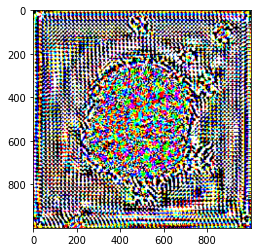

In [31]:
import matplotlib.pyplot as plt
plt.imshow(x_test_adv[0].numpy().transpose(1,2,0))